In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/sample_submission.csv
/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv
/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/test.csv


In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import GradientBoostingRegressor

CLIP_FLOOR = 1.0   #Negative/zero costs clipped to this value before log transform     

FREQ_THRESHOLD = 0.01 #Group categories with frequency < 1% (for robustness)   

N_SPLITS_CV = 10         # Increased to 10 for maximum robustness

#Loading data and performing EDA


train_df = pd.read_csv("/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/test.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hospital_Id           5000 non-null   object 
 1   Supplier_Name         5000 non-null   object 
 2   Supplier_Reliability  4413 non-null   float64
 3   Equipment_Height      4717 non-null   float64
 4   Equipment_Width       4557 non-null   float64
 5   Equipment_Weight      4540 non-null   float64
 6   Equipment_Type        4401 non-null   object 
 7   Equipment_Value       5000 non-null   float64
 8   Base_Transport_Fee    5000 non-null   float64
 9   CrossBorder_Shipping  5000 non-null   object 
 10  Urgent_Shipping       5000 non-null   object 
 11  Installation_Service  5000 non-null   object 
 12  Transport_Method      3929 non-null   object 
 13  Fragile_Equipment     5000 non-null   object 
 14  Hospital_Info         5000 non-null   object 
 15  Rural_Hospital       

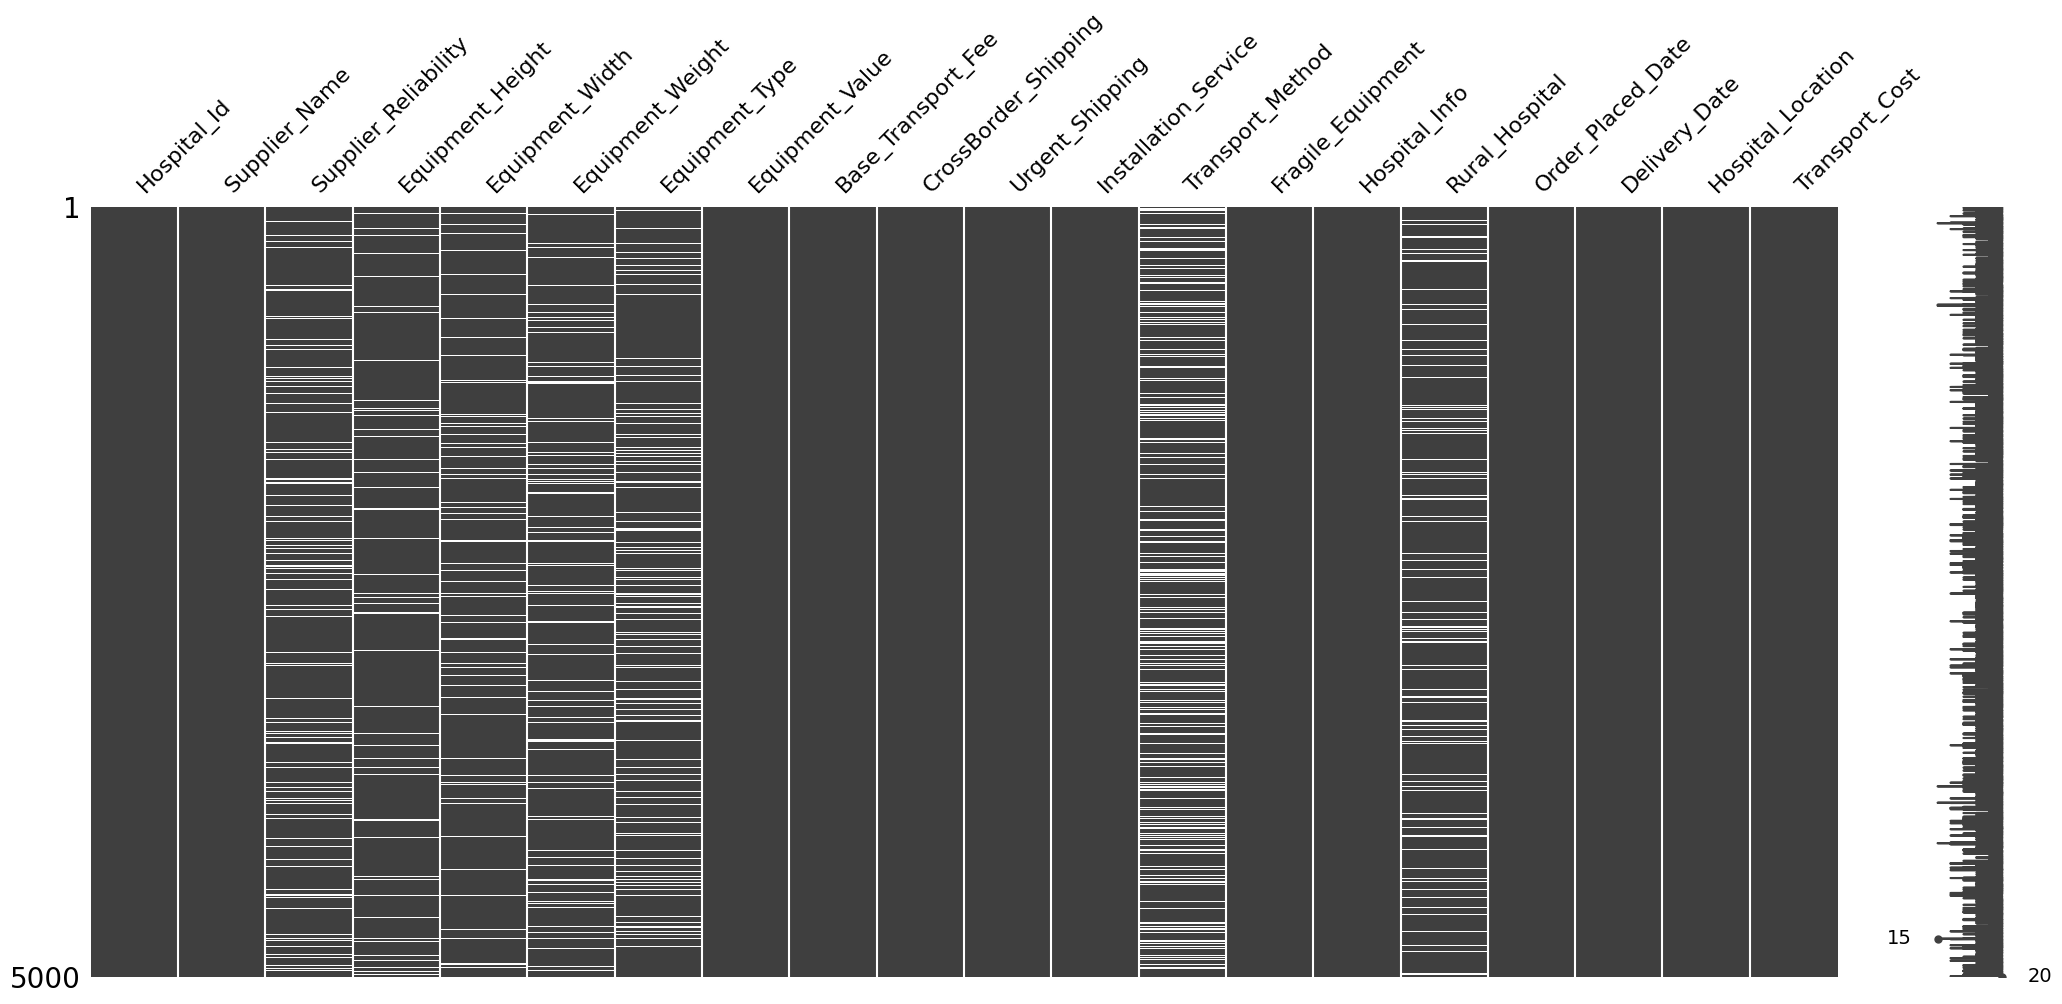

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


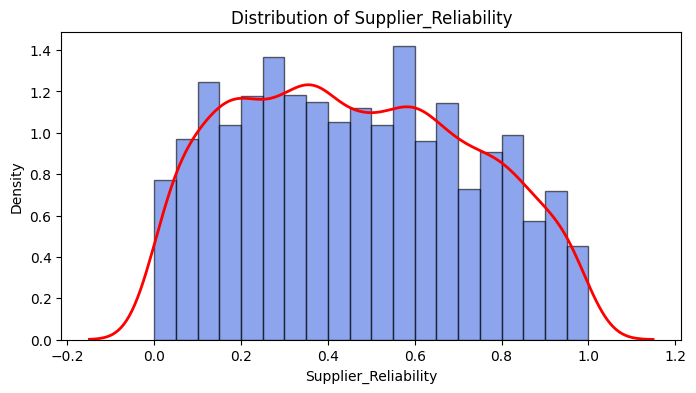

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


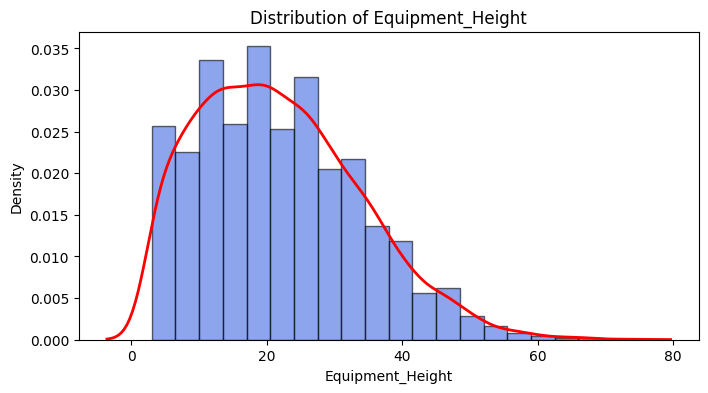

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


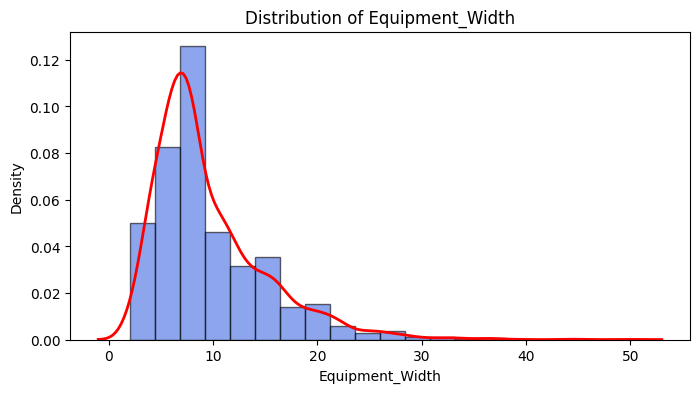

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


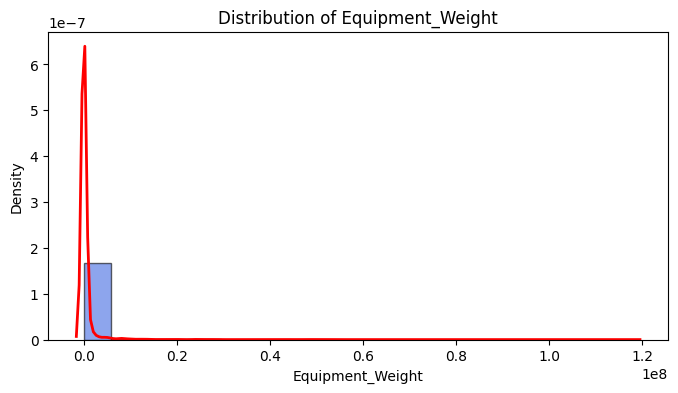

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


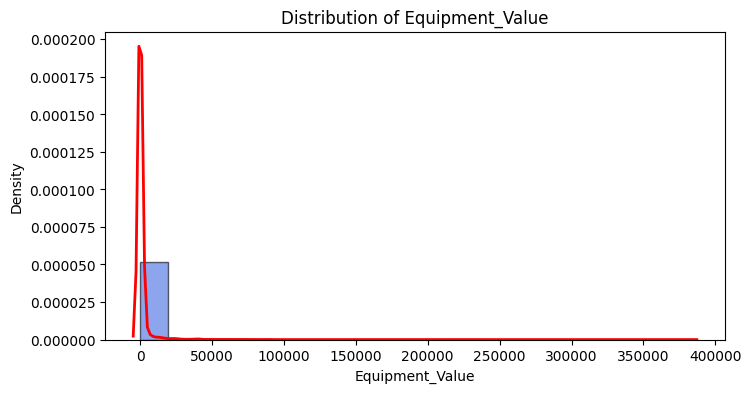

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


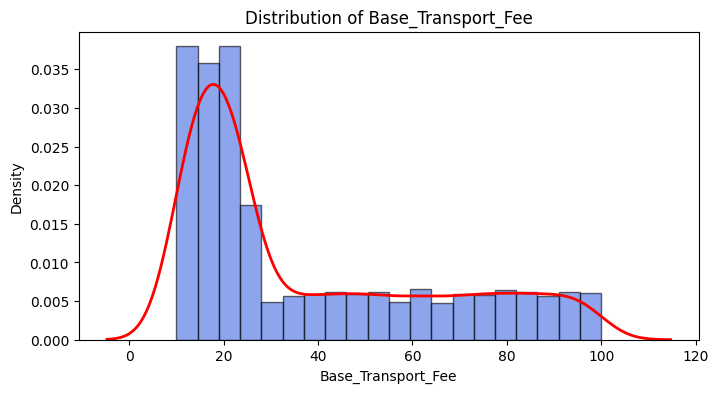

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


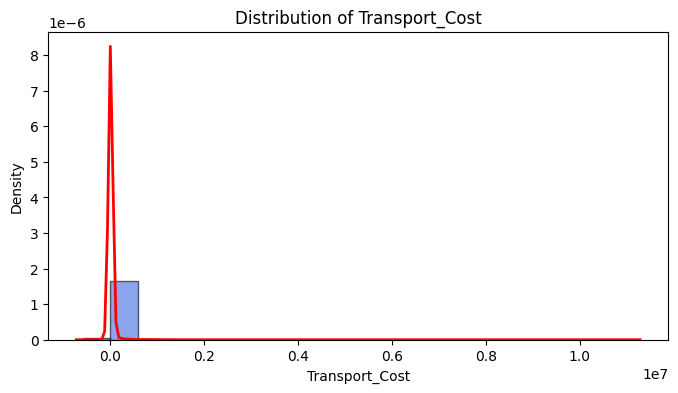

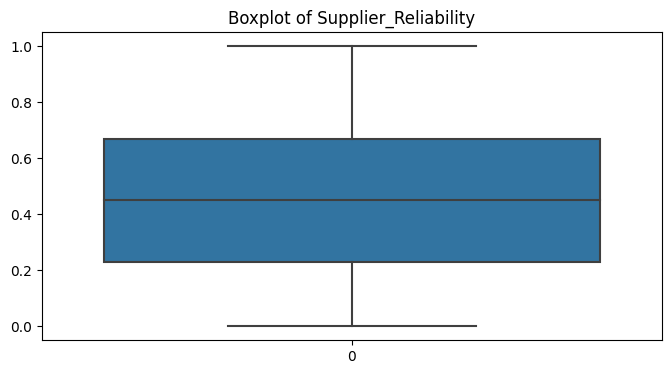

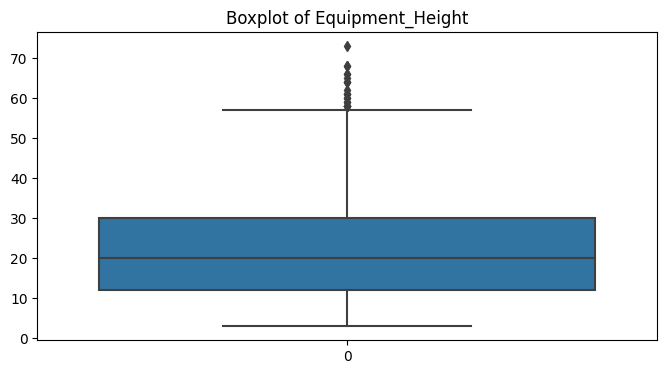

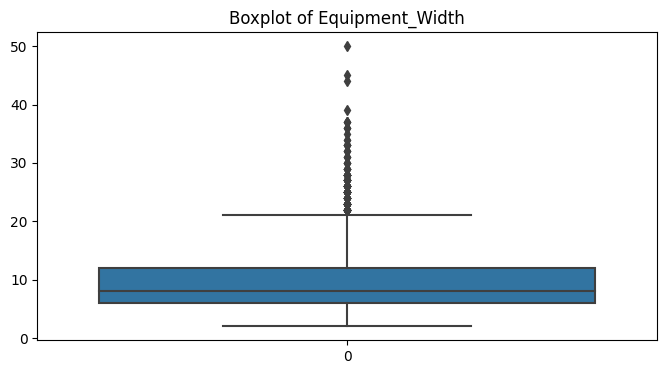

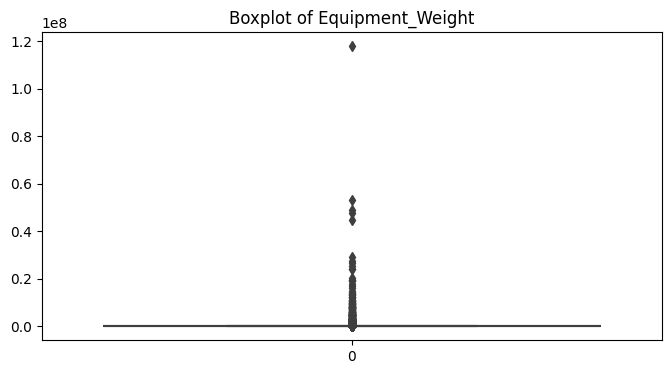

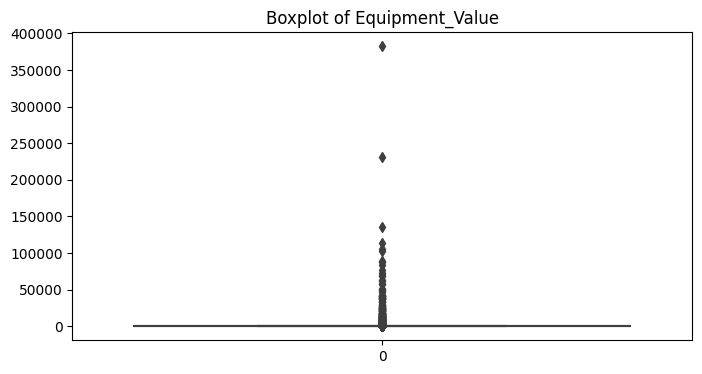

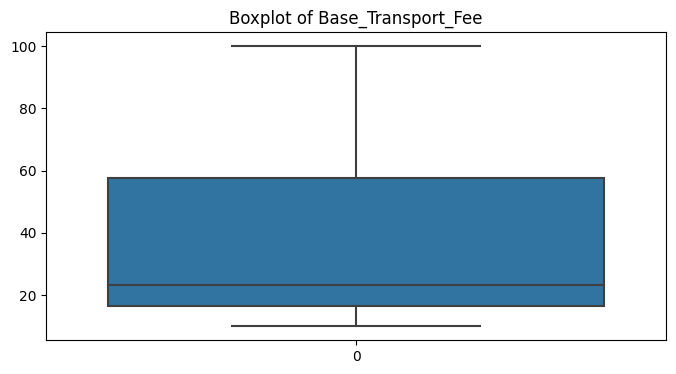

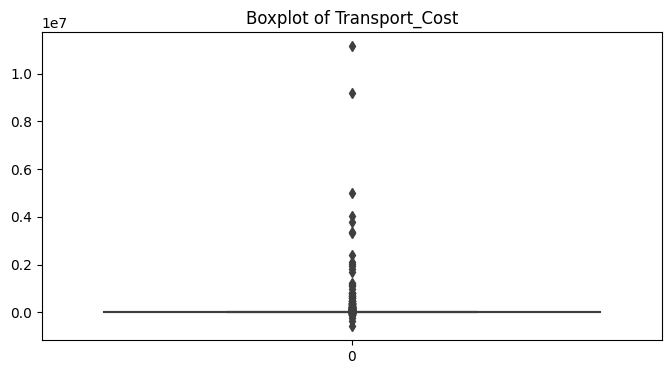

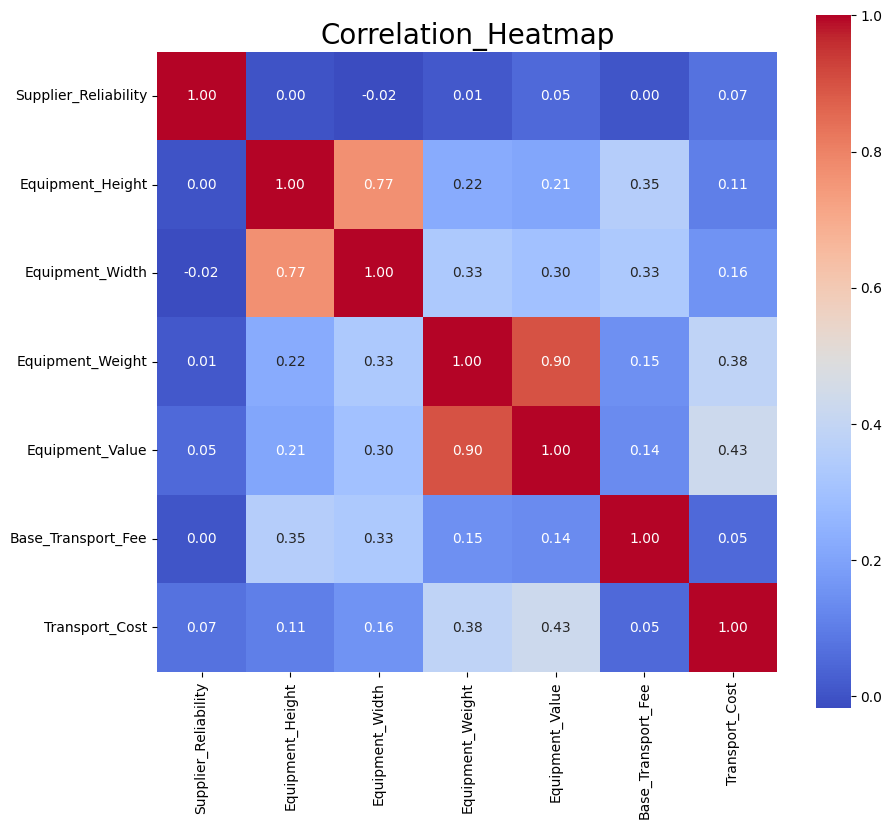

In [3]:
train_df.head()#Seeing 1st 5 rows of train.csv
train_df.shape #Seeing no. of rows and columns in train.csv
test_df.shape #Seeing no. of rows and columns in test.csv

train_df.info()

print(train_df.isnull() .sum()) #Gives total number of null values in each column

train_df.drop_duplicates(inplace=True) #Dropping duplicates if any

nullity_value_percentages_train_df=(train_df.isnull().sum()/train_df.shape[0])*100 #Null value percentages
print(nullity_value_percentages_train_df)

columns_with_null_values = nullity_value_percentages_train_df[nullity_value_percentages_train_df>0]
print(columns_with_null_values) #Columns with finite number of null values

print(train_df.describe().T)


import missingno as msno
msno.matrix(train_df)
plt.show()

num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns #Numerical columns
cat_cols = train_df.select_dtypes(include=['object']).columns #Categorical columns
#Plotting distributions of numerical columns
for col in num_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(train_df[col], bins=20, color='royalblue', alpha=0.6, edgecolor='black', density=True)
    sns.kdeplot(train_df[col], color='red', linewidth=2)
    plt.title(f'Distribution of {col}')
    plt.show()

#Plotting boxplots of numerical columns for outlier detection
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
     
#Plotting correlation heatmap of numerical columns
corr=train_df[num_cols].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation_Heatmap", fontsize=20)
plt.show()

In [4]:
test_ids = test_df['Hospital_Id']
train_df.set_index('Hospital_Id', inplace=True) 
#Hospital_Id column used to label rows both in train and test data
test_df.set_index('Hospital_Id', inplace=True)

#Creating training and testing dataframes from given datasets
y_train = train_df["Transport_Cost"].copy()
X_train = train_df.drop(columns=["Transport_Cost"]).copy()
X_test = test_df.copy()
#Combining for consistent feature engineering
combined_df = pd.concat([X_train, X_test], axis=0)

# Best-performing transformation: Clip and Log
y_train_transformed = np.log(y_train.clip(lower=CLIP_FLOOR))

# Dropping unnecessary columns and adding useful ones

combined_df['Order_Placed_Date'] = pd.to_datetime(combined_df['Order_Placed_Date'], format='%m/%d/%y', errors='coerce')
combined_df['Delivery_Date'] = pd.to_datetime(combined_df['Delivery_Date'], format='%m/%d/%y', errors='coerce')

#New features such as no of days taken to deliver after order,day of order,month of order have been added 
combined_df['Delivery_Lag_Days'] = (combined_df['Delivery_Date'] - combined_df['Order_Placed_Date']).dt.days.fillna(0).astype(int)
combined_df['Order_Day_of_Week'] = combined_df['Order_Placed_Date'].dt.dayofweek
combined_df['Order_Month'] = combined_df['Order_Placed_Date'].dt.month

#Equipment volume and density are also added
combined_df['Equipment_Volume'] = combined_df['Equipment_Height'] * combined_df['Equipment_Width']
combined_df['Equipment_Density'] = combined_df['Equipment_Weight'] / (combined_df['Equipment_Volume'] + 1e-6)
#Dropping unnecesary columns  
combined_df.drop(columns=['Order_Placed_Date', 'Delivery_Date', 'Supplier_Name', 'Hospital_Location'], inplace=True, errors='ignore')

# Map Yes to 1 and No to 0 for binary columns
binary_map = {'Yes': 1, 'No': 0}
binary_cols_to_map = ['CrossBorder_Shipping', 'Installation_Service', 'Rural_Hospital'] 
for col in binary_cols_to_map:
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].map(binary_map).fillna(0)
    
binary_cols = binary_cols_to_map + ['Urgent_Shipping', 'Fragile_Equipment'] 

#  Group Low-Frequency Categorical Features : A good preprocessing step
categorical_cols_to_group = ['Equipment_Type', 'Transport_Method', 'Hospital_Info']
for col in categorical_cols_to_group:
    if col in combined_df.columns:
        train_counts = combined_df.iloc[:len(X_train)][col].value_counts(normalize=True)
        low_freq_cats = train_counts[train_counts < FREQ_THRESHOLD].index
        combined_df[col] = np.where(combined_df[col].isin(low_freq_cats), 'Other', combined_df[col])


# Re-separate the data after performing  certain preoprocessing steps on both training and testing dataframes
X_train_clean = combined_df.iloc[:len(X_train)]
X_test_clean = combined_df.iloc[len(X_train):]


# Define Preprocessing Pipeline  
#Standardisation important for lasso

#Finding numerical and Categorical columns
numeric_cols = [col for col in X_train_clean.select_dtypes(include=np.number).columns.tolist() if col not in binary_cols]
categorical_cols = X_train_clean.select_dtypes(include=['object']).columns.tolist()

#Numerical columns median imputation is done 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  
])#Scaling mandatory for lasso

#Categorical columns One-hot encoding is done
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

In [5]:
#Fit transform ensures all scaling and imputation is done on X_train_clean
#Processed training data
X_train_processed = preprocessor.fit_transform(X_train_clean)

# Check  for any NaN values in training data
if np.any(np.isnan(X_train_processed)):
    print("Missing values found in the processed training data")
    print()
    total_missing = np.sum(np.isnan(X_train_processed))
    print("Total missing values:", total_missing)
else:
    print("No missing values found in the processed training data.")

#Processed test data
# Use only transform on the test data 
X_test_processed = preprocessor.transform(X_test_clean)

# Check any NaN values in test data
if np.any(np.isnan(X_test_processed)):
    print("Missing values found in the processed test data\n")
    total_missing = np.sum(np.isnan(X_test_processed))
    print("Total missing values:", total_missing)
else:
    print("No missing values found in the processed test data")

No missing values found in the processed training data.
No missing values found in the processed test data


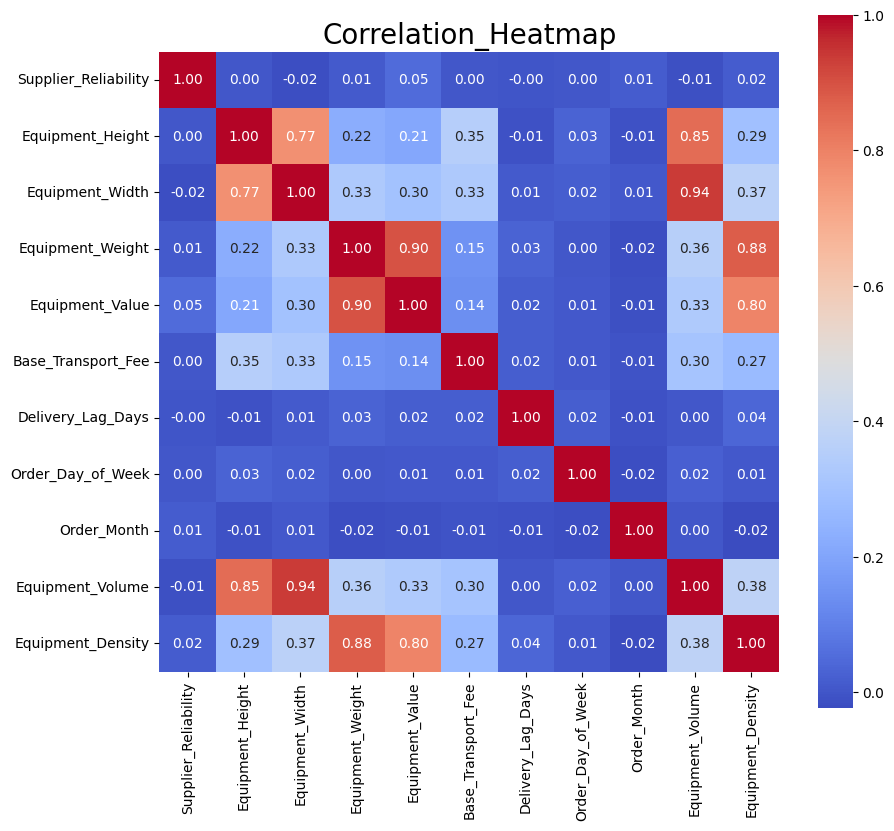

In [6]:
corr=X_train_clean[numeric_cols].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation_Heatmap", fontsize=20)
plt.show()


In [7]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold

gbr = GradientBoostingRegressor(
    random_state=42,
    n_iter_no_change=10,
    validation_fraction=0.1
)

gbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gbr', gbr)
])

param_grid = {
    'gbr__n_estimators': [100, 200],
    'gbr__learning_rate': [0.05, 0.1],
    'gbr__max_depth': [3, 4],
    'gbr__min_samples_split': [2, 5],
    'gbr__min_samples_leaf': [1, 2]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=gbr_pipeline,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_clean, y_train_transformed)
best_gbr = grid.best_estimator_

print("Best Params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)






y_test_pred_log = best_gbr.predict(X_test_clean)
y_test_pred = np.exp(y_test_pred_log)  # Inverse log transform


submission = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__min_samples_leaf': 2, 'gbr__min_samples_split': 5, 'gbr__n_estimators': 100}
Best CV RMSE: 2.0620837700050694
Submission file saved as submission.csv
